<a href="https://colab.research.google.com/github/Small-Fiend/CUDA_Laboratory/blob/main/VectorSum/VectorSum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import math
import random

import numpy as np
from numba import cuda, int32
from tabulate import tabulate

import time
import datetime

import matplotlib.pyplot as plt

In [53]:
# Размер блоков TPB
TPB = 16
# Количество итераций для вычисления среднего затраченного времени
ITER_COUNT = 10

Сложение элементов вектора на CPU при помощи функции "sum"

In [73]:
M = 100
V = np.random.randint(1000, size=M)

# Cтартовое время
start_time = datetime.datetime.now() 
sum_vec = sum(V)
# Затраченное время
t1 = datetime.datetime.now() - start_time
print('Cумма элементов вектора = ', sum_vec)
print ('Затраченное время: ', str(t1)) 

Cумма элементов вектора =  46303
Затраченное время:  0:00:00.000163


Сложение элементов вектора на GPU

In [74]:
@cuda.jit
def GPU_sum_vect(vec, res):
  shared_v = cuda.shared.array(shape = TPB, dtype=int32)
  # номер нити в блоке
  t_x = cuda.threadIdx.x
  # номер блока, в котором находится нить
  block = cuda.blockIdx.x
  # индекс, под которым работает каждый конкретный поток
  index = block*TPB + t_x

  shared_v[t_x] = 0

  if index < vec.shape[0]:
    shared_v[t_x] = vec[index]
    if t_x == 0:
      sum = 0
      # вычисление в общей памяти
      for i in range (TPB):
        sum += shared_v[i]
      cuda.atomic.add(res, 0, sum)

# Результирующий вектор
result_vector = np.zeros(1, dtype=np.int32)

In [75]:
def body_GPU(M, TPB, d_vec, d_res):
  # Перенос данных в глобальную память GPU
  d_vec = cuda.to_device(V)
  d_res = cuda.to_device(result_vector)

  # Вызов ядра
  GPU_sum_vect[M, TPB](d_vec, d_res)

  # Перенос вывода с устройства на хост
  GPU_sum = d_res.copy_to_host()
  return GPU_sum

In [76]:
# Стартовое время
start_time = datetime.datetime.now()

GPU_res = body_GPU(M, TPB, d_vec, d_res)

# Затраченное время
t3 = datetime.datetime.now() - start_time

print('Сумма элементов вектора = ', GPU_res[0])
print ('Затраченное время: ', str(t3))


Сумма элементов вектора =  46303
Затраченное время:  0:00:00.223131


Проведем эксперименты на векторах размером 1 000...1 000 000 значений и сравним затраченное время.

In [77]:
# для записи результатов
result_list = []

# Размер вектора от 1 000 до 1 000 000, 
# Расчет производится на блоках элементов TPB = 16
# Количество итераций для вычисления среднего затраченного времени ITER_COUNT = 10

for bpg in range(50, 60000, 120):
  grid_size = bpg
  block_size = TPB
  
  M = bpg * TPB
  
  CPU_time = 0
  GPU_time = 0

  for _ in range(ITER_COUNT):
    # создаем ветор размера М
    V = np.random.randint(1000, size=M)
    # создаем нулевой список для записи результатов
    results = np.zeros(1, dtype=np.int32)
    
    # Cтартовое время CPU
    start = time.time()
    S1 = sum(V)
    # Затраченное время
    sum_time = time.time() - start
    CPU_time += sum_time

    # Стартовое время GPU
    start = time.time() 

    body_GPU(M, TPB, V, results)

    # Затраченное время
    gpu_time = time.time() - start
    GPU_time += gpu_time

    

  res = [M, CPU_time / ITER_COUNT, GPU_time / ITER_COUNT]
  #print(res)
  result_list.append(res)

In [78]:
print(tabulate(result_list, headers=['Matrix size', 'CPU time', 'GPU time']))

  Matrix size     CPU time    GPU time
-------------  -----------  ----------
          800  0.000170565  0.00130379
         2720  0.000490165  0.0011544
         4640  0.000705624  0.00123479
         6560  0.00156054   0.00167804
         8480  0.00155563   0.00135844
        10400  0.00180662   0.00125031
        12320  0.00200746   0.00120354
        14240  0.00223389   0.00122197
        16160  0.00265281   0.00119853
        18080  0.00301466   0.00141976
        20000  0.00315592   0.00128593
        21920  0.003793     0.00173514
        23840  0.00379126   0.00131865
        25760  0.00415318   0.00130587
        27680  0.00482688   0.00141177
        29600  0.00473154   0.00140364
        31520  0.00514519   0.00139909
        33440  0.00614281   0.00141745
        35360  0.00584152   0.00142434
        37280  0.00653074   0.00184352
        39200  0.0061157    0.00135558
        41120  0.00745881   0.00168767
        43040  0.0070955    0.00139866
        44960  0.007162   

Визуализация полученных результатов

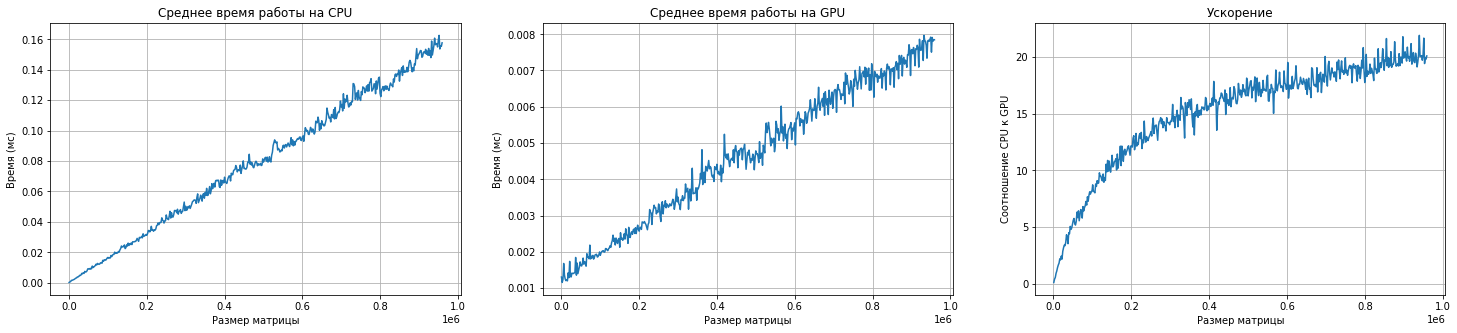

In [84]:
result_matr = np.array(result_list)
plt.figure(figsize=(25, 5))

plt.subplot(1, 3, 1)
plt.title('Среднее время работы на CPU')
plt.plot(result_matr[:, 0], result_matr[:, 1])
plt.xlabel('Размер матрицы')
plt.ylabel('Время (мс)')
plt.grid()

plt.subplot(1, 3, 2)
plt.title('Среднее время работы на GPU')
plt.plot(result_matr[:, 0], result_matr[:, 2])
plt.xlabel('Размер матрицы')
plt.ylabel('Время (мс)')
plt.grid()

plt.subplot(1, 3, 3)
plt.title('Ускорение')
plt.plot(result_matr[:, 0], (result_matr[:, 1]/result_matr[:, 2]))
plt.xlabel('Размер матрицы')
plt.ylabel('Соотношение CPU к GPU')
plt.grid()

# Выводы

Из полученных результатов видно, что при вычислении больших массивов значений скорость вычисления на GPU выше, чем на CPU. Однако для массивов небольших размеров CPU подходит лучше.